# Problem Set 2: Window based Stereo Matching
---
## Setup

In [3]:
# IPython magic
%load_ext autoreload
%autoreload 2
# Matplotlib magic
%matplotlib inline

In [4]:
# Imports
import cv2
import matplotlib.pyplot as plt
import numpy as np
# Matplotlib params
plt.rcParams['figure.figsize'] = (14.0, 6.0)
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['figure.titlesize'] = 20
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [5]:
# Change to True if Jupyter Widgets extension is installed
IS_INTERACTIVE = False
# Turn widgets on-off
if IS_INTERACTIVE:
    from ipywidgets import interact
else:
    def interact(**kwargs):
        def decorator(f):
            return f();
        return decorator

---
## 1. SSD Stereo (Simple Image)

In [16]:
# Load images
img1l = cv2.imread('Data/leftTest.png', 0)
img1r = cv2.imread('Data/rightTest.png', 0)

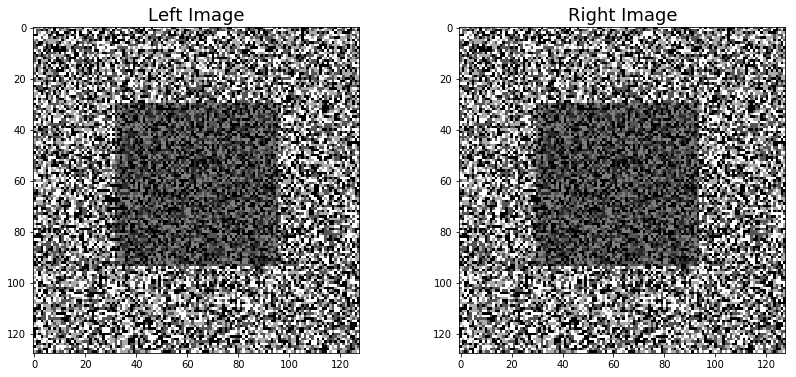

In [17]:
# Plot
fig, ax = plt.subplots(1, 2)
ax[0].set_title('Left Image')
ax[0].imshow(img1l)
ax[1].set_title('Right Image')
ax[1].imshow(img1r);

In [28]:
max_offset = 5
window_size = 9
k = window_size // 2
h, w = img1l.shape
factor = 255 / max_offset
depth = np.zeros((h, w), np.uint8)
for y in range(k, h-k):
    for x in range(k, w-k):
        ssd_min = np.inf
        offset_min = 0
        for offset in range(max_offset):
            ssd = 0
            for v in range(y-k, y+k):
                for u in range(x-k, x+k):
                    if u+offset > w-k:
                        break
                    ssd += (img1l[v, u] - img1r[v, u+offset]) ** 2
            if ssd < ssd_min:
                ssd_min = ssd
                offset_min = offset
        depth[y, x] = offset_min * factor

/home/ayush/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in ubyte_scalars


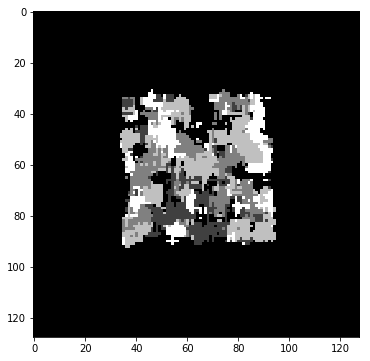

In [29]:
plt.imshow(depth)

---
## 2. SSD Stereo (First Image)

In [31]:
# Load images
img2l = cv2.imread('Data/proj2-pair1-L.png', 0)
img2r = cv2.imread('Data/proj2-pair1-R.png', 0)

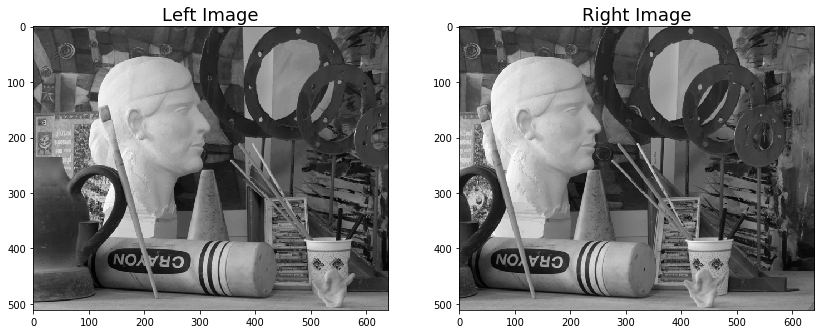

In [32]:
# Plot
fig, ax = plt.subplots(1, 2)
ax[0].set_title('Left Image')
ax[0].imshow(img2l)
ax[1].set_title('Right Image')
ax[1].imshow(img2r);

---
## 3. SSD Stereo with Noise (First Image)

---
## 4. Normalized Correlation Stereo (First Image)

---
## 5. Stereo (Second Image)